# Bayesian Modeling

This notebook uses the MNIST dataset to sample two sets of image labels and classify them using Bayes method.

In [1]:
import scipy.io
import numpy as np

In [2]:
# set the random seed
np.random.seed(42)

In [3]:
def generate_data():
    """This function generates the training and testing data for our model."""
    # load the training mat files
    file0 = scipy.io.loadmat('../data/train_0_img.mat')
    file1 = scipy.io.loadmat('../data/train_1_img.mat')
    
    # get the training data from the files
    train0 = file0.get('target_img')
    train1 = file1.get('target_img')
    
    # reshape the training data
    train0 = np.transpose(train0, axes=[2, 0, 1])
    train1 = np.transpose(train1, axes=[2, 0, 1])
    
    # shuffle the data
    np.random.shuffle(train0)
    np.random.shuffle(train1)
    
    # create new training data arrays
    new_train0 = train0[:5000]
    new_train1 = train1[:5000]
    
    # save the new training data arrays
    scipy.io.savemat('../data/digit0_train.mat', {'target_img': new_train0})
    scipy.io.savemat('../data/digit1_train.mat', {'target_img': new_train1})
    
    # repeat the procedure for the testing data
    file2 = scipy.io.loadmat('../data/test_0_img.mat')
    file3 = scipy.io.loadmat('../data/test_1_img.mat')
    
    # get the testing data from the files
    test0 = file2.get('target_img')
    test1 = file3.get('target_img')
    
    # reshape the testing arrays
    test0 = np.transpose(test0, axes=[2, 0, 1])
    test1 = np.transpose(test1, axes=[2, 0, 1])
    
    # save the testing data
    scipy.io.savemat('../data/digit0_test.mat', {'target_img': test0})
    scipy.io.savemat('../data/digit1_test.mat', {'target_img': test1})

In [4]:
# generate the training and testing data
generate_data()

In [5]:
# load the training and testing .mat files
file0 = scipy.io.loadmat('../data/digit0_train.mat')
file1 = scipy.io.loadmat('../data/digit1_train.mat')
file2 = scipy.io.loadmat('../data/digit0_test.mat')
file3 = scipy.io.loadmat('../data/digit1_test.mat')

# get the training and testing data
train0 = file0.get('target_img')
train1 = file1.get('target_img')
test0 = file2.get('target_img')
test1 = file3.get('target_img')

# data successfully loaded
print([len(train0), len(train1), len(test0), len(test1)])
print('Your trainset and testset are generated successfully!')

[5000, 5000, 980, 1135]
Your trainset and testset are generated successfully!


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(image):
    """This function plots a given image."""
    plt.imshow(image)
    plt.show()

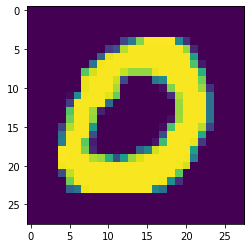

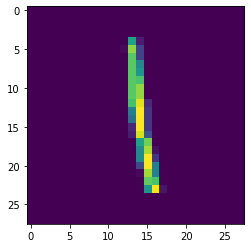

In [7]:
# examples
visualize(train0[0])
visualize(train1[0])

In [8]:
def generate_features(data):
    """
    This function generates two features for a given data set.
    
    Inputs:
    ------
    data - numpy ndarray of images [i x j x k]
    
    Outputs:
    -------
    feature one - average brightness of each provided image
    feature two - standard deviation of the brightness of each image
    """
    feature1 = np.array([np.mean(image) for image in data])
    feature2 = np.array([np.std(image) for image in data])
    
    return feature1, feature2

In [9]:
# test function
f01, f02 = generate_features(train0)
f11, f12 = generate_features(train1)

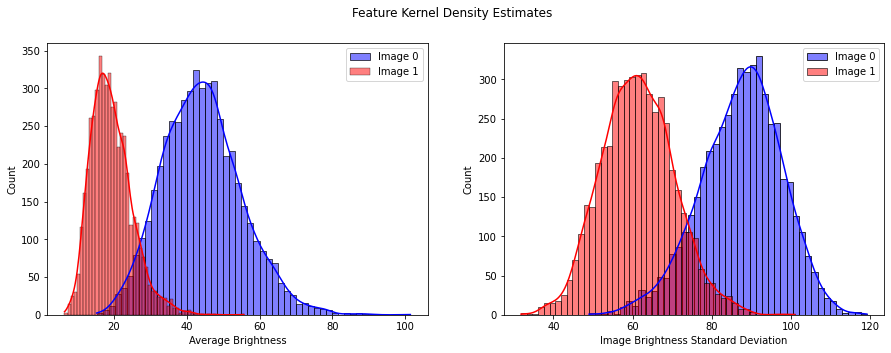

In [10]:
# visualize features
import seaborn as sns
from scipy.stats import norm

hist, axs = plt.subplots(1, 2, figsize=(15,5))
hist.suptitle('Feature Kernel Density Estimates');

sns.histplot(f01, kde=True, ax=axs[0], label='Image 0', color='blue');
sns.histplot(f11, kde=True, ax=axs[0], label='Image 1', color='red');
axs[0].set_xlabel('Average Brightness');
axs[0].legend();

sns.histplot(f02, kde=True, ax=axs[1], label='Image 0', color='blue');
sns.histplot(f12, kde=True, ax=axs[1], label='Image 1', color='red');
axs[1].set_xlabel('Image Brightness Standard Deviation');
axs[1].legend();

In [11]:
# combine feature arrays
f1, f2 = np.concatenate((f01, f11), axis=None), np.concatenate((f02, f12), axis=None)

In [12]:
import itertools

def generate_training_parameters(*args):
    """
    This function generates training parameters for the Bayesian Model
    given a set of input features.
    
    Inputs:
    ------
    It is assumed that the inputs to this function are the
    previously calculated feature 1 and feature 2.
    
    Outputs:
    -------
    parameter one  - mean of feature 1
    parameter two  - variance of feature 1
    parameter 2N-1 - mean of feature N
    parameter 2N   - variance of feature N
    """
    parameters = [[np.mean(feature), np.var(feature)] for feature in args]
    parameters = np.array(list(itertools.chain.from_iterable(parameters)))
    
    return parameters

In [13]:
# calculate training parameters
parameters = generate_training_parameters(f01, f02, f11, f12)

In [14]:
def naive_bayes(x, μ, σ):
    """This function computes the Naive Bayes prediction for a given sample."""
    return (1 / (σ * np.sqrt(2 * np.pi))) * np.exp(-((x - μ)**2 / (2 * σ**2)))

In [15]:
def prior(sample, *args):
    """This function computes the prior probability for a given dataset."""
    numerator = len(sample)
    denominator = sum([len(data) for data in args])
    
    return numerator / denominator

In [16]:
# calculate priors
p_y0 = prior(train0, train0, train1)
p_y1 = prior(train1, train0, train1)

In [17]:
# calculate testing features
t01, t02 = generate_features(test0)
t11, t12 = generate_features(test1)

In [18]:
def likelihood(data, μ, σ):
    """This function computes the likelihood: P(X|y)."""
    return np.array([naive_bayes(x, μ, σ) for x in data])

In [19]:
def compute_probabilities(f1, f2, parameters):
    """This function computes the class probabilities."""
    # unpack the training parameters
    p1, p2, p3, p4, p5, p6, p7, p8 = parameters
    
    # likelihood calculation: P(X|class 0)
    p_x1_y0 = likelihood(f1, p1, np.sqrt(p2))
    p_x2_y0 = likelihood(f2, p3, np.sqrt(p4))
    p_x_y0 = p_x1_y0 * p_x2_y0

    # likelihood calculation: P(X|class 1)
    p_x1_y1 = likelihood(f1, p5, np.sqrt(p6))
    p_x2_y1 = likelihood(f2, p7, np.sqrt(p8))
    p_x_y1 = p_x1_y1 * p_x2_y1
    
    return p_x_y0, p_x_y1

In [20]:
# compute class probabilities for 0 testing images
p_x_y0, p_x_y1 = compute_probabilities(t01, t02, parameters)
prob_y0 = p_x_y0 * p_y0
prob_y1 = p_x_y1 * p_y1

In [21]:
# predict class
prediction0 = [0 if p0 > p1 else 1 for p0, p1 in zip(prob_y0, prob_y1)]

In [22]:
# score 0 image classification
score0 = prediction0.count(0) / len(prediction0)
print('Testing accuracy for 0 labeled images: {}%'.format(100 * round(score0,4)))

Testing accuracy for 0 labeled images: 91.73%


Repeat the process for the 1 test images

In [23]:
# compute class probabilities
p_x_y0, p_x_y1 = compute_probabilities(t11, t12, parameters)
prob_y0 = p_x_y0 * p_y0
prob_y1 = p_x_y1 * p_y1

In [24]:
# predict class
prediction1 = [1 if p1 > p0 else 0 for p0, p1 in zip(prob_y0, prob_y1)]

In [25]:
# score 1 image classification
score1 = prediction1.count(1) / len(prediction1)
print('Testing accuracy for 0 labeled images: {}%'.format(100 * round(score1,4)))

Testing accuracy for 0 labeled images: 92.33%
